In [1]:
# Import relevant libraries
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
#rcParams['font.sans-serif'] = ['Tahoma']

import math

import datetime

import numpy as np

import networkx as nx

import os

In [2]:
# Defines TodaysDate, which is used in output-file name
def TodaysDate():
        
    Today = datetime.date.today()
    TodaysDate = Today.strftime('%d%b%Y')
    
    return TodaysDate

In [3]:
# Validate the DNACodingSequence based on (1) its Lenght AND (2) QualityScore of each nucleotide 

def DNACodingSequence(DNASequence,
                      QualitySequence,
                      StartSequence,
                      StopSequence,
                      cDNA_MinLength,
                      cDNA_MaxLength,
                      QualityScore):
#utilises ONLY ONE StopSequence, returns ONLY ONE CodingSequence
    
    QualityScoreString = """!"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~"""
    ThresholdQualityString = QualityScoreString[QualityScore:]
            
    StartIndex = DNASequence.find(StartSequence) + len(StartSequence)
    StopIndex = DNASequence.rfind(StopSequence)
    CodingSequence =  DNASequence[StartIndex:StopIndex]
    if cDNA_MinLength <= len(CodingSequence) and len(CodingSequence) <= cDNA_MaxLength and len(CodingSequence)%3 == 0:
        for Character in QualitySequence[StartIndex:StopIndex]:
            if Character not in ThresholdQualityString:
                return None
        return str(CodingSequence)

In [4]:
def ComplementarySequence(String):
    DNAComplement = {'A':'T','C':'G','G':'C','T':'A'}
    RNAComplement = {'A':'U','C':'G','G':'C','U':'A'}
    
    ComplementarySequence = ''
    
    if 'T' in String:
        for i in range(len(String)):
            ComplementarySequence = ComplementarySequence + DNAComplement[String[i]]
    elif 'U' in String:
        for i in range(len(String)):
            ComplementarySequence = ComplementarySequence + RNAComplement[String[i]]
    return ComplementarySequence

In [5]:
def ReverseSequence(String):
    ReverseSequence = ''
    i = len(String) - 1
    while i >= 0:
        ReverseSequence = ReverseSequence + String[i]
        i -= 1
    return ReverseSequence

In [6]:
# Define Translation of RNASequence into Peptide (peptide can be encoded as DNA or as RNA)

def Translation(CodingSequence):

    # Set RNA TranslationCode
    TranslationCode = {
                    'AAA':'K','AAC':'N','AAG':'K','AAU':'N',
                    'ACA':'T','ACC':'T','ACG':'T','ACU':'T',
                    'AGA':'R','AGC':'S','AGG':'R','AGU':'S',
                    'AUA':'I','AUC':'I','AUG':'M','AUU':'I',
                    
                    'CAA':'Q','CAC':'H','CAG':'Q','CAU':'H',
                    'CCA':'P','CCC':'P','CCG':'P','CCU':'P',
                    'CGA':'R','CGC':'R','CGG':'R','CGU':'R',
                    'CUA':'L','CUC':'L','CUG':'L','CUU':'L',
                    
                    'GAA':'E','GAC':'D','GAG':'E','GAU':'D',
                    'GCA':'A','GCC':'A','GCG':'A','GCU':'A',
                    'GGA':'G','GGC':'G','GGG':'G','GGU':'G',
                    'GUA':'V','GUC':'V','GUG':'V','GUU':'V',
                    
                    'UAA':'#','UAC':'Y','UAG':'*','UAU':'Y',
                    'UCA':'S','UCC':'S','UCG':'S','UCU':'S',
                    'UGA':'&','UGC':'C','UGG':'W','UGU':'C',
                    'UUA':'L','UUC':'F','UUG':'L','UUU':'F'
                        }
    # Stop Codons are as follows:
    # UAA (ochre) — #
    # UAG (amber) — *
    # UGA (opal) — &
                    
    TranscriptionCode = {'A':'A','C':'C','G':'G','T':'U','U':'T'}
    
    ReverseComplement = ReverseSequence(ComplementarySequence(CodingSequence))
    
    # Convert DNA to RNA
    RNASequence = ''
    for Nucleotide in ReverseComplement:
        RNASequence += TranscriptionCode.get(Nucleotide,'X')
        
    #RNASequence-Test Print
    #print (RNASequence)
        
    Peptide = ''
    while len(RNASequence) != 0:
        Peptide += TranslationCode.get(RNASequence[0:3],'Do not fuck with me!')
        RNASequence = RNASequence[3:]
    return Peptide

In [7]:
# Define SingleSelectionRoundSummary function, which returns the Occurence of CodingSequences, grouped by Peptide
# SingleSelectionRoundSummary = {PeptideY:    {CodingSequence_YZ:    Occurence_YZ}}

def SingleSelectionRoundSummary(fastqFileLocation, StartSequence, StopSequence, cDNA_MinLength, cDNA_MaxLength, QualityScore):
    
    RawDataFile = open(fastqFileLocation, 'r')
    Lines = RawDataFile.readlines()
    RawDataFile.close

    # Create an empty SingleSelectionRoundSummary dictionary to store the results from a single cycle of selection
    # SingleSelectionRoundSummary = {PeptideY:    {CodingSequence_YZ:    Occurence_YZ}}
    SingleSelectionRoundSummary = {}
   
    # Populate SingleSelectionRoundSummary with the results from a single round of selection
    # Go through the NGS-data file (.fastq) line by line
    for i,Line in enumerate(Lines):
        # Check that the line contains a valid sequence
        if StartSequence in Line and StopSequence in Line:
            CodingSequence = DNACodingSequence(Line, Lines[i + 2], StartSequence, StopSequence, cDNA_MinLength, cDNA_MaxLength, QualityScore)                      
            if CodingSequence != None:
                # Translated DNA or RNA sequence into PeptideSequence
                PeptideSequence = Translation(CodingSequence)
                # Add sequence to a SingleSelectionRoundSummary
                if PeptideSequence not in SingleSelectionRoundSummary:
                    SingleSelectionRoundSummary[str(PeptideSequence)] = {str(CodingSequence) : 1}
                else:
                    if CodingSequence not in SingleSelectionRoundSummary[str(PeptideSequence)]:
                        SingleSelectionRoundSummary[str(PeptideSequence)][str(CodingSequence)] = 1
                    else:
                        SingleSelectionRoundSummary[str(PeptideSequence)][str(CodingSequence)] += 1

    return SingleSelectionRoundSummary

In [8]:
# Define HammingDistance, which returns the number of mismatches between two Sequences
def HammingDistance(Sequence1, Sequence2):
    
    if len(Sequence1) < len(Sequence2):
        Sequence1 = Sequence1 + (len(Sequence2) - len(Sequence1)) * '%'
    elif len(Sequence1) > len(Sequence2):
        Sequence2 = Sequence2 + (len(Sequence1) - len(Sequence2)) * '%'
    
    HammingDistance = 0
    for i in range(len(Sequence1)):
        if Sequence1[i] == Sequence2[i]:
            HammingDistance = HammingDistance
        else:
            HammingDistance = HammingDistance + 1
            
    return HammingDistance

In [9]:
# Define HammingDistanceBasedFormating, which returns FormatedSequence, such that mismatches are capitalised, and the rest of the FormatedSequence is lowercase 
def HammingDistanceBasedFormating(Sequence1, Sequence2):
    
    if len(Sequence1) < len(Sequence2):
        Sequence1 = Sequence1 + (len(Sequence2) - len(Sequence1)) * '-'
    elif len(Sequence1) > len(Sequence2):
        Sequence2 = Sequence2 + (len(Sequence1) - len(Sequence2)) * '-'
    
    HammingDistance = 0
    FormatedSequence2 = ''
    for i in range(len(Sequence1)):
        if Sequence1[i] == Sequence2[i]:
            FormatedSequence2 += Sequence2[i].lower()
            HammingDistance = HammingDistance
        else:
            FormatedSequence2 += Sequence2[i]
            HammingDistance = HammingDistance + 1            
    return FormatedSequence2

In [10]:
# Define CompleteSelectionSummary, which returns the Occurence of CodingSequences, grouped by Peptide, grouped by SelectionRound
# SelectionSummary = {SelectionRound_X:    {PeptideXY:    {CodingDNA_XYZ:    Occurence_XYZ}}}
def CompleteSelectionSummary(DataFolderLocation,
                             StartSequence,
                             StopSequence,
                             cDNA_MinLength,
                             cDNA_MaxLength,
                             QualityScore):
    # Create an empty SelectionSummary dictionary to store the results from all the rounds of selection
    CompleteSelectionSummary = {}
    
    for file in os.listdir(DataFolderLocation):
        
        FileLocation = os.path.join(DataFolderLocation, file)
        
        #(1.A) Extract the round number from the file name (file name should have two digit number before full stop — '00.')    
        if file.endswith('.fastq'): # this conditional is necessary; without it some shit appears in the beginning of the file list
            RoundNumberFirstDigit = file[file.find('.')-2]
            RoundNumberSecondDigit = file[file.find('.')-1]
            if RoundNumberFirstDigit == '0':
                RoundNumber = int(RoundNumberSecondDigit)
                # RoundNumber_Test Print
                #print RoundNumber
            elif RoundNumberFirstDigit != '0':
                RoundNumber = int(file[file.find('.')-2 : file.find('.')])
                # RoundNumber_Test Print
                #print RoundNumber
            
            #(1.B) Extract single round results
            SelectionRoundSummary = SingleSelectionRoundSummary(FileLocation, StartSequence, StopSequence, cDNA_MinLength, cDNA_MaxLength, QualityScore)
             
            #(1.C) Populate ConcatenatedResultsList
            CompleteSelectionSummary[RoundNumber] = SelectionRoundSummary
            
            # ConcatenatedResultsList-Test Print
            #print ConcatenatedResultsList
            
    return CompleteSelectionSummary

In [11]:
# Define PeptidesOccurences_BY_Round, which returns the Occurences of Peptides groupped by round
# PeptidesOccurences_BY_Round = {Round_X:    {PeptideXY:    Occurence_XY}}
def PeptidesOccurences_BY_Round(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore):
    SelectionSummary = CompleteSelectionSummary(DataFolderLocation, StartSequence, StopSequence, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    
    PeptidesOccurences_BY_Round = {}
    for Round in SelectionSummary:
        PeptidesOccurences_IN_Round = {}
        for Peptide in SelectionSummary[Round]:
            PeptidesOccurences_IN_Round[Peptide] = sum(SelectionSummary[Round][Peptide].values())
        PeptidesOccurences_BY_Round[Round] = PeptidesOccurences_IN_Round
        
    return PeptidesOccurences_BY_Round

In [12]:
# Define DNAsOccurences_BY_Round, which returns the Occurences of DNAs groupped by round
# DNAsOccurences_BY_Round = {Round_X:    {DNA_XY:    Occurence_XY}}
def DNAsOccurences_BY_Round(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore):
    SelectionSummary = CompleteSelectionSummary(DataFolderLocation, StartSequence, StopSequence, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    
    DNAsOccurences_BY_Round = {}
    for Round in SelectionSummary:
        DNAsOccurences_IN_Round = {}
        for Peptide in SelectionSummary[Round]:
            for DNA in SelectionSummary[Round][Peptide]:
                DNAsOccurences_IN_Round[DNA] = SelectionSummary[Round][Peptide][DNA]
        DNAsOccurences_BY_Round[Round] = DNAsOccurences_IN_Round

    return DNAsOccurences_BY_Round

In [13]:
# Define TotalReads_BY_Round, which returns number of reads by round
# TotalReads_BY_Round = {Round_X:    TotalReads_X}
def TotalReads_BY_Round(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore):
    SelectionSummary = CompleteSelectionSummary(DataFolderLocation, StartSequence, StopSequence, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    Peptides_BY_Round = PeptidesOccurences_BY_Round(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    
    TotalReads_BY_Round = {}
    for Round in SelectionSummary:
        TotalReads_BY_Round[Round] = sum(Peptides_BY_Round[Round].values())
        
    return TotalReads_BY_Round

In [14]:
# Define BaseRoundSortedPeptidesList, which returns list of peptides in base round sorted by their occurence
# BaseRoundSortedPeptidesList = [Peptide_1, ..., Peptide_N]; Occurence(Peptide_1) > ... > Occurence(Peptide_N)
def BaseRoundSortedPeptidesList(DataFolderLocation, BaseSelectionRoundNumber):
    Peptides_BY_Round = PeptidesOccurences_BY_Round(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore)  
            
    PeptidesOccurencesInBaseRound = Peptides_BY_Round[BaseSelectionRoundNumber]
    BaseRoundSortedPeptidesList = sorted(PeptidesOccurencesInBaseRound, key = PeptidesOccurencesInBaseRound.get, reverse = True)
    
    return BaseRoundSortedPeptidesList

In [15]:
# Define BaseRoundSortedDNAsList, which returns list of DNAs in base round sorted by their occurence
# BaseRoundSortedDNAsList = [DNA_1, ..., DNA_N]; Occurence(DNA_1) > ... > Occurence(DNA_N)
def BaseRoundSortedDNAsList(DataFolderLocation, BaseSelectionRoundNumber):
    DNAs_BY_Round = DNAsOccurences_BY_Round(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore)  
            
    DNAsOccurences_IN_BaseRound = DNAs_BY_Round[BaseSelectionRoundNumber]
    BaseRoundSortedDNAsList = sorted(DNAsOccurences_IN_BaseRound, key = DNAsOccurences_IN_BaseRound.get, reverse = True)
    
    return BaseRoundSortedDNAsList

In [16]:
def PeptidesRank_IN_BaseRound(DataFolderLocation, BaseSelectionRoundNumber):
    Peptides_BY_Round = PeptidesOccurences_BY_Round(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    BaseRoundSortedPeptides = BaseRoundSortedPeptidesList(DataFolderLocation, BaseSelectionRoundNumber)
    
    BasePeptideCount = 0
    PeptideRank = 1
    
    PeptidesRank_IN_BaseRound = {}
    
    for Peptide in BaseRoundSortedPeptides:
        PeptideCount = Peptides_BY_Round[BaseSelectionRoundNumber][Peptide]
        if PeptideCount < BasePeptideCount:
            PeptideRank += 1
        
        PeptidesRank_IN_BaseRound[Peptide] = PeptideRank
        BasePeptideCount = PeptideCount
        
    return PeptidesRank_IN_BaseRound

In [17]:
# Occurences is a bad word in here


# Define DNAClonesOccurences_BY_Round_BY_Peptide, which returns number of clones for each peptide groupped by round.
# DNAClonesOccurences_BY_Round_BY_Peptide = {SelectionRound_X:    {PeptideXY:    DNAClonesOccurences}}
def DNAClonesOccurences_BY_Round_BY_Peptide(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore):
    SelectionSummary = CompleteSelectionSummary(DataFolderLocation, StartSequence, StopSequence, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    
    DNAClonesOccurences_BY_Round_BY_Peptide = {}
    for Round in SelectionSummary:
        DNAClonesOccurences_BY_Peptide = {}
        for Peptide in SelectionSummary[Round]:
            DNAClonesOccurences_BY_Peptide[Peptide] = len(SelectionSummary[Round][Peptide])
        DNAClonesOccurences_BY_Round_BY_Peptide[Round] = DNAClonesOccurences_BY_Peptide
        
    return DNAClonesOccurences_BY_Round_BY_Peptide

In [18]:
# Define PeptidesAppearances_BY_Round, which returns for each peptide in selection a list of rounds in which this peptide appears.
# PeptidesAppearances_BY_Round = {Peptide_X:    [Round_A, ..., Round_N]}
def PeptidesAppearances_BY_Round(BaseRoundSortedPeptidesList, PeptidesOccurences_BY_Round):
    
    PeptidesAppearances_BY_Round = {}
    
    for Peptide in BaseRoundSortedPeptidesList:
        PeptidesAppearances_BY_Round[Peptide] = []
        for Round in PeptidesOccurences_BY_Round:
            if Peptide in PeptidesOccurences_BY_Round[Round]:
                PeptidesAppearances_BY_Round[Peptide] += [Round]
    return PeptidesAppearances_BY_Round

In [19]:
# Define DNAsAppearances_BY_Round, which returns for each DNA in selection a list of rounds in which this DNA appears.
# DNAsAppearances_BY_Round = {DNA_X:    [Round_A, ..., Round_N]}
def DNAsAppearances_BY_Round(BaseRoundSortedDNAsList, DNAsOccurences_BY_Round):
    
    DNAsAppearances_BY_Round = {}
    
    for DNA in BaseRoundSortedDNAsList:
        DNAsAppearances_BY_Round[DNA] = []
        for Round in DNAsOccurences_BY_Round:
            if DNA in DNAsOccurences_BY_Round[Round]:
                DNAsAppearances_BY_Round[DNA] += [Round]
    return DNAsAppearances_BY_Round

In [20]:
# Define SelectionSummaryReport, which, for the TopNPeptidesNumber, returns a summary table (.txt) and provides a summary grpaph (.png).
def SelectionSummaryReport(DataFolderLocation,
                           BaseSelectionRoundNumber,
                           TopNPeptidesNumber,
                           StartSequence,
                           StopSequence,
                           cDNA_MinLength,
                           cDNA_MaxLength,
                           QualityScore,
                           FileName):
    
    today = TodaysDate() 
    
    SelectionSummaryFileNameCSV = str(today) + 'SelectionSummary' + FileName + '.csv'
    SelectionSummaryReportFile = open(SelectionSummaryFileNameCSV, 'w')
    
    SelectionSummary = CompleteSelectionSummary(DataFolderLocation, StartSequence, StopSequence, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    SortedRoundsList = sorted(SelectionSummary.keys())
    
    Peptides_BY_Round = PeptidesOccurences_BY_Round(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    TotalPeptides_BY_Round = TotalReads_BY_Round(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    
    BaseRoundSortedPeptides = BaseRoundSortedPeptidesList(DataFolderLocation, BaseSelectionRoundNumber)
    BaseRoundTopSortedPeptides = BaseRoundSortedPeptides[0 : (TopNPeptidesNumber)]

    BaseRoundPeptidesRank = PeptidesRank_IN_BaseRound(DataFolderLocation, BaseSelectionRoundNumber)
    #print (BaseRoundSortedPeptides)
    
        
    SelectionSummaryReportFile.write('peptide sequence' + ',' +
                                     'rank (#)' + ',' +
                                     'cDNA mutants' + ',')
    for Round in SortedRoundsList:
        SelectionSummaryReportFile.write('C' +
                                         str(Round) +
                                         ' count (#) [frequency(%)]' + ',')
    SelectionSummaryReportFile.write('\n')
    
    for Peptide in BaseRoundTopSortedPeptides:
        BaseRoundPeptideFraction = float((Peptides_BY_Round[Round].get(Peptide, 0)))/float(TotalPeptides_BY_Round[BaseSelectionRoundNumber])
        PeptideRank = BaseRoundPeptidesRank[Peptide]
        FormatedPeptide = HammingDistanceBasedFormating(BaseRoundTopSortedPeptides[0], Peptide)
        PeptidecDNAMutants = len(SelectionSummary[BaseSelectionRoundNumber][Peptide])
        SelectionSummaryReportFile.write(FormatedPeptide + ',' +
                                         str(PeptideRank) + ',' +
                                         str(PeptidecDNAMutants) + ',')
            
        for Round in SortedRoundsList:
            PeptideFraction = float((Peptides_BY_Round[Round].get(Peptide, 0)))/float(TotalPeptides_BY_Round[Round])

            BaseFraction = PeptideFraction
            
            SelectionSummaryReportFile.write(str(Peptides_BY_Round[Round].get(Peptide, 0)) +
                                             ' [' + '{:.1%}'.format(PeptideFraction) + ']' + ',')
            
            BaseFraction = PeptideFraction
        SelectionSummaryReportFile.write('\n')
        
    SelectionSummaryReportFile.write('total count (#)' + ',' + ',' + ',')
    for Round in SortedRoundsList:
        SelectionSummaryReportFile.write(str(TotalPeptides_BY_Round[Round]) + ',')
    SelectionSummaryReportFile.write('\n\n\n')
            
    SelectionSummaryReportFile.close()
    
#-------------------------------------------------------------------------------
   
    # Create a figure of size 8x6 inches, 500 dots per inch
    plt.figure(figsize = (8, 6),
               dpi = 500)
    # Create 'ggplot' style
    plt.style.use('fivethirtyeight')
    # Create a new subplot from a grid of 1x1
    Graph = plt.subplot(1, 1, 1)
    
    Xs = []
    Ys = []

    # Map colours onto lines  
    cNorm  = matplotlib.colors.Normalize(vmin = 0,
                                         vmax = TopNPeptidesNumber - 1)
    scalarMap = matplotlib.cm.ScalarMappable(norm = cNorm,
                                             cmap = 'gist_rainbow')
    
    PeptideLabels = []
    
    for Peptide in BaseRoundTopSortedPeptides:
    #for Peptide in Top24PeptidesKDs:
        PeptidesFractions_BY_Round = []
        for Round in SortedRoundsList:
            PeptidesFractions_BY_Round += [float((Peptides_BY_Round[Round].get(Peptide, 0)))/float(TotalPeptides_BY_Round[Round])]
        
        x = SortedRoundsList
        y = PeptidesFractions_BY_Round
        Xs += x
        Ys += y
        
        PeptideRank = BaseRoundPeptidesRank[Peptide]
        #PeptideColour = scalarMap.to_rgba(PeptideRank)
        PeptideColour = scalarMap.to_rgba(BaseRoundTopSortedPeptides.index(Peptide))
        FormatedPeptide = HammingDistanceBasedFormating(BaseRoundTopSortedPeptides[0], Peptide)
        
        PeptideLabel =  FormatedPeptide + ' (' + str(PeptideRank) +')'
        
        #Set PeptideLabel
        PeptideLabels += [PeptideLabel]
        
        plt.plot(x, y,
                 'o-',
                 c = PeptideColour,
                 lw = 2.0,
                 ms = 4.0,
                 mew = 0.1,
                 mec = '#191919')

    XMin = min(Xs) - 0.05*(max(Xs) - min(Xs))
    XMax = max(Xs) + 0.05*(max(Xs) - min(Xs))
    YMin = min(Ys) - 0.05*(max(Ys) - min(Ys))
    YMax = max(Ys) + 0.05*(max(Ys) - min(Ys))
    
    plt.axis([XMin, XMax, YMin, YMax])
    
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Selection Cycle (#)',
               fontsize = 10)
    plt.ylabel('Peptide Fraction (%)',
               fontsize = 10)
    
    legend = plt.legend(PeptideLabels,
                        title = 'cyclic-peptide random region',
                        loc = 'upper center',
                        bbox_to_anchor = (0.5, -0.10),
                        fancybox = True,
                        shadow = False,
                        fontsize = 10,
                        ncol = 3)
    
    Graph.get_legend().get_title().set_size('small')
    
    SelectionSummaryFileNamePNG = str(today) + 'SelectionSummary' + FileName + '.png'
    
    plt.savefig(SelectionSummaryFileNamePNG,
                bbox_extra_artists = [legend],
                bbox_inches = 'tight',
                dpi = 300)
    plt.show()
    plt.close()

In [21]:
def DNAMutantsAnalysis(DataFolderLocation,
                       BaseSelectionRoundNumber,
                       TopNPeptidesNumber,
                       StartSequence,
                       StopSequence,
                       FileName):
    
    today = TodaysDate() 
    
    DNAMutantsAnalysisFileNameCSV =  str(today) + 'DNAsMutantsAnalysis' + FileName + '.csv'
    DNAMutantsAnalysisFile = open(DNAMutantsAnalysisFileNameCSV, 'w')
    
    SelectionSummary = CompleteSelectionSummary(DataFolderLocation, StartSequence, StopSequence, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    SortedRoundsList = sorted(SelectionSummary.keys())
    
    Peptides_BY_Round = PeptidesOccurences_BY_Round(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    TotalPeptides_BY_Round = TotalReads_BY_Round(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    
    BaseRoundSortedPeptides = BaseRoundSortedPeptidesList(DataFolderLocation, BaseSelectionRoundNumber)
    BaseRoundTopSortedPeptides = BaseRoundSortedPeptides[0 : (TopNPeptidesNumber)]
    
    DNAClones_BY_Round_BY_Peptide = DNAClonesOccurences_BY_Round_BY_Peptide(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    
    DNAMutantsAnalysisFile.write('peptide sequence' + ',')
    for Round in SortedRoundsList:
        DNAMutantsAnalysisFile.write('round # ' + str(Round) + ' DNA clones (#)' + ',')
    DNAMutantsAnalysisFile.write('\n')
    
    for Peptide in BaseRoundTopSortedPeptides:
        DNAMutantsAnalysisFile.write(Peptide + ',')
        for Round in SortedRoundsList:
            DNAMutantsAnalysisFile.write(str(DNAClones_BY_Round_BY_Peptide[Round].get(Peptide, 0)) + ',')
        DNAMutantsAnalysisFile.write('\n')
        
#    DNAClonesSummaryReportFile.write('total #' + ',')
#    for Round in SortedRoundsList:
#        DNAClonesSummaryReportFile.write(str(TotalPeptides_BY_Round[Round]) + ',')
#    DNAClonesSummaryReportFile.write('\n\n\n')
    
#    DNAClonesSummaryReportFile.write('peptide sequence' + ',')
#    for Round in SortedRoundsList:
#        DNAClonesSummaryReportFile.write('round # ' + str(Round) + ' fraction (%)' + ',')
#    DNAClonesSummaryReportFile.write('\n')
    
#    for Peptide in BaseRoundTopSortedPeptides:
#        DNAClonesSummaryReportFile.write(Peptide + ',')
#        for Round in SortedRoundsList:
#            PeptideFraction = float((Peptides_BY_Round[Round].get(Peptide, 0)))/float(TotalPeptides_BY_Round[Round])
#            DNAClonesSummaryReportFile.write('{:.3%}'.format(PeptideFraction) + ',')
#        DNAClonesSummaryReportFile.write('\n')
            
    DNAMutantsAnalysisFile.close()
    
#-------------------------------------------------------------------------------        
#    plt.style.use('fivethirtyeight') # just to create 'ggplot' style
    
#    Xs = []
#    Ys = []    
#    for Peptide in BaseRoundTopSortedPeptides:
#        SortedDNAClones_BY_Peptide = []
#        for Round in SortedRoundsList:
#            SortedDNAClones_BY_Peptide += [DNAClones_BY_Round_BY_Peptide[Round].get(Peptide, 0)]
        
#        x = SortedRoundsList
#        y = SortedDNAClones_BY_Peptide
#        Xs += x
#        Ys += y
#        plt.plot(x, y,
#                'o-',
#                lw = 2.0,
#                ms = 4.0,
#                mew = 0.1,
#                mec = '#191919')
                
#    XMin = min(Xs) - 0.05*(max(Xs) - min(Xs))
#    XMax = max(Xs) + 0.05*(max(Xs) - min(Xs))
#    YMin = min(Ys) - 0.05*(max(Ys) - min(Ys))
#    YMax = max(Ys) + 0.05*(max(Ys) - min(Ys))
    
#    plt.axis([XMin, XMax, YMin, YMax])
    
#    plt.xlabel('Selection Round #', fontsize=14)
#    plt.ylabel('DNA Clones #', fontsize=14)
    
#    legend = plt.legend(BaseRoundTopSortedPeptides, loc='upper center', bbox_to_anchor=(0.5, -0.15),
#                        fancybox=True, shadow=False, ncol=2)
    
#    DNAMutantsAnalysisFileNamePNG = str(today) + 'DNAsMutantsAnalysis' + FileName + '.png'
    
#    plt.savefig(DNAMutantsAnalysisFileNamePNG, bbox_extra_artists=[legend],bbox_inches='tight', dpi = 300)
#    plt.show()
#    plt.close()
#-------------------------------------------------------------------------------    
    # Create a figure of size 8x6 inches, 500 dots per inch
    plt.figure(figsize = (8, 6),
               dpi = 500)
    # Create 'ggplot' style
    plt.style.use('fivethirtyeight')
    # Create a new subplot from a grid of 1x1
    Graph = plt.subplot(1, 1, 1)
    
#    PeptideDNAClonesNumber_IN_BaseRound = []
#    PeptideOccurence_IN_BaseRound = []

    # Map colours onto lines
    cNorm  = matplotlib.colors.Normalize(vmin = 0,
                                         vmax = len(BaseRoundSortedPeptides) - 1)
    scalarMap = matplotlib.cm.ScalarMappable(norm = cNorm,
                                             cmap = 'gist_rainbow')

    RoundIndex = BaseSelectionRoundNumber

    Xs = []
    Ys = []        
    for Peptide in DNAClones_BY_Round_BY_Peptide[RoundIndex]:
        PeptideDNAClonesNumber_IN_BaseRound = math.log(DNAClones_BY_Round_BY_Peptide[RoundIndex].get(Peptide, 0), 2)
        PeptideOccurence_IN_BaseRound = math.log(Peptides_BY_Round[RoundIndex].get(Peptide, 0), 2)
        
        PeptideColour = scalarMap.to_rgba(BaseRoundSortedPeptides.index(Peptide))
    
        x = PeptideDNAClonesNumber_IN_BaseRound
        y = PeptideOccurence_IN_BaseRound
        Xs += [x]
        Ys += [y]
        
        plt.plot(x, y,
                'o',
                c = PeptideColour,
                ms = 5.0,
                mew = 0.1,
                mec = '#191919')

    XMin = min(Xs) - 0.05*(max(Xs) - min(Xs))
    XMax = max(Xs) + 0.05*(max(Xs) - min(Xs))
    YMin = min(Ys) - 0.05*(max(Ys) - min(Ys))
    YMax = max(Ys) + 0.05*(max(Ys) - min(Ys))
    
    plt.axis([XMin, XMax, YMin, YMax])
        
    XLabel = 'log$2$ (DNA Clones #)' #$_$ makes subscript possible
    plt.xlabel(XLabel, fontsize = 14)
    YLabel = 'log$2$ (Peptide Occurence)'
    plt.ylabel(YLabel, fontsize = 14)
    
    legend = plt.legend(BaseRoundSortedPeptides,
                        loc = 'upper center',
                        bbox_to_anchor = (0.5, -0.15),
                        fancybox = True,
                        shadow = False,
                        ncol = 4)
    
    DNAClonesAnalysisFileNamePNG = str(today) + 'DNAsMutantsAnalysisRegression' + 'R' + str(Round) + FileName + '.png'
    
    plt.savefig(DNAClonesAnalysisFileNamePNG, bbox_extra_artists=[legend], bbox_inches='tight', dpi = 300)
    plt.show()
    plt.close()

In [22]:
def PeptidesRelatednessAnalysis(DataFolderLocation,
                                BaseSelectionRoundNumber,
                                TopNPeptidesNumber,
                                StartSequence,
                                StopSequence,
                                cDNA_MinLength,
                                cDNA_MaxLength,
                                QualityScore,
                                FileName):
    
    # to extract TodaysDate
    today = TodaysDate()
    
    # to collect DNAs-based summary information By_Round
    DNAs_BY_Round = DNAsOccurences_BY_Round(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    TotalDNAs_BY_Round = TotalReads_BY_Round(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    BaseRoundSortedDNAs = BaseRoundSortedDNAsList(DataFolderLocation, BaseSelectionRoundNumber)
    DNAsAppearances = DNAsAppearances_BY_Round(BaseRoundSortedDNAs, DNAs_BY_Round)
    
    # to collect Peptides-based summary information By_Round
    Peptides_BY_Round = PeptidesOccurences_BY_Round(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    TotalPeptides_BY_Round = TotalReads_BY_Round(DataFolderLocation, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    BaseRoundSortedPeptides = BaseRoundSortedPeptidesList(DataFolderLocation, BaseSelectionRoundNumber)
    PeptidesAppearances = PeptidesAppearances_BY_Round(BaseRoundSortedPeptides, Peptides_BY_Round)
    
    SelectionSummary = CompleteSelectionSummary(DataFolderLocation, StartSequence, StopSequence, cDNA_MinLength, cDNA_MaxLength, QualityScore)
    SortedRoundsList = sorted(SelectionSummary.keys())
    
    # to create a disjoint graph (Forest), based on DNAs in the BaseRound (joint subgraphs are the Trees and the unique DNA sequences are the Leaves)
    BaseRoundDNAsForest = nx.Graph()
    # to add nodes (Leaves, unique DNA sequences) to the BaseRoundDNAsForest disjoint graph
    BaseRoundDNAsForest.add_nodes_from(BaseRoundSortedDNAs)
    # to add edges (Twigs, DNA-to-DNA connections based on the hamming distance between unique DNA sequences) to the BaseRoundDNAsForest so that disjoint graphs (stand alone Trees) can be identified
    UsedNodes = []
    for DNA1 in BaseRoundSortedDNAs:
        UsedNodes += [DNA1]
        for DNA2 in BaseRoundSortedDNAs:
            if DNA2 not in UsedNodes and HammingDistance(DNA1, DNA2) == 1:
                BaseRoundDNAsForest.add_edge(DNA1,DNA2,
                                                MutationsNumber = 1)
    # to extract individual joint subgraphs (stand alone Trees) from the disjoint graph (Forest)
    BaseRoundDNAsTrees = list(nx.connected_component_subgraphs(BaseRoundDNAsForest, copy = True))
    
    # to create a PeptideSummaryDNAPerspectiveCSV file
    PeptidesSummaryFileNameCSV =  str(today) + 'PeptideFamiliesSummary' + FileName + '.csv'
    PeptidesSummaryFile = open(PeptidesSummaryFileNameCSV, 'w')
    
    # to convert list of DNAs Trees into a list of Peptides Trees Leaves
    PeptidesTreesLeaves = []
    for DNAsTree in BaseRoundDNAsTrees:
        PeptideLeaves = []
        for DNA in DNAsTree:
            Peptide = Translation(DNA)
            if Peptide not in PeptideLeaves:
                PeptideLeaves += [Peptide]
        PeptidesTreesLeaves += [PeptideLeaves]
    # to sort the resulting list of lists from the largest to smallest
    PeptidesTreesLeaves.sort(key = len, reverse = True)
    
    # to fix the coordinates of the origin of the graph
    Positions = {}
    X_0_Coordinate = 1
    Y_0_Coordinate = 0
    Y_X0_Coordinate = 0
    
    TreesXCoordinates = []
    
    
    PeptideGraphFigure = plt.figure()
    PeptideGraph = PeptideGraphFigure.add_subplot(1, 1, 1)
    
    #to introduce PeptideFamilyCounter
    MultiplePeptideFamilyCounter = 0
    #to introduce SinglePeptideFamilyCounter
    SinglePeptideFamilyCounter = 0
    #to introduce PeptideFamilySize
    PeptideTreeSize = []
    
    
    # to create a tree for each set of Peptides Trees Leaves 
    for PeptideLeaves in PeptidesTreesLeaves:
        
        PeptideTree = nx.Graph()
        # to convert each Peptide (Leave) into a node of a Peptide graph (PeptideLeave on a PeptideTree)
        
        for Peptide in PeptideLeaves:
            PeptideTree.add_node(Peptide,
                                        Occurence = Peptides_BY_Round[BaseSelectionRoundNumber][Peptide],
                                        FirstAppearance = min(PeptidesAppearances[Peptide]))
        # to join the Peptide nodes of a graph by edges (Twigs)
        for Peptide1 in PeptideLeaves:
            for Peptide2 in PeptideLeaves:
                if HammingDistance(Peptide1, Peptide2) == 1:
                    PeptideTree.add_edge(Peptide1,Peptide2)
        
        # to identify the RootPeptide of a PeptideTree graph
        TreePeptidesOccurences = nx.get_node_attributes(PeptideTree, 'Occurence')              
        RootPeptide = max(TreePeptidesOccurences, key=TreePeptidesOccurences.get)
        
        # to create a dictionary holder for Peptide and their properties (Predecessor and Occurrence)
        TreePeptides = {}
        TreePeptides[RootPeptide] = [0, '', 0, PeptideTree.node[RootPeptide]['Occurence'], PeptideTree.node[RootPeptide]['FirstAppearance']]
        TreePeptidesList = PeptideTree.nodes()
        TreePeptidesList.remove(RootPeptide)

        for Peptide in TreePeptidesList:
            PeptidePredecessor = nx.shortest_path(PeptideTree, source = Peptide, target = RootPeptide, weight = None)[1]
            # PredecessorOccurence can be used to sort the Peptides, but does not seem to be useful
            PredecessorOccurence = PeptideTree.node[PeptidePredecessor]['Occurence']
            PeptideOccurence = PeptideTree.node[Peptide]['Occurence']

            TreePeptides[Peptide] = [PeptidePredecessor, PredecessorOccurence, PeptideOccurence]
            
        
        # to sort Peptides in a PeptideTree by their distance to the RootPeptide
        Peptides_BY_DistanceToTheRoot = {}
        for Peptide in PeptideTree.nodes():
            DistanceToTheRoot = nx.shortest_path_length(PeptideTree, source = Peptide, target = RootPeptide, weight = None)
            if DistanceToTheRoot not in Peptides_BY_DistanceToTheRoot:
                Peptides_BY_DistanceToTheRoot[DistanceToTheRoot] = [Peptide]
            else:
                Peptides_BY_DistanceToTheRoot[DistanceToTheRoot] += [Peptide]
        
        # to identify the largest group of equidistanced peptides 
        MaxPeptidesNumber = max(map(lambda k: len(Peptides_BY_DistanceToTheRoot[k]), Peptides_BY_DistanceToTheRoot))

        SortedPeptides_BY_DistanceToTheRoot = {}
        # to sort Peptides by their distance to the RootPeptide
        for DistanceToTheRoot in Peptides_BY_DistanceToTheRoot:

            EquidistantPeptides = Peptides_BY_DistanceToTheRoot[DistanceToTheRoot]

            EquidistantPeptides = sorted(EquidistantPeptides, key = lambda Peptide: (TreePeptides[Peptide][2]), reverse = True)
            # PredecessorOccurence can be used to sort the Peptides, but does not seem to be useful
            # EquidistantPeptides = sorted(EquidistantPeptides, key = lambda Peptide: (TreePeptides[Peptide][1]), reverse = True)
            EquidistantPeptides = sorted(EquidistantPeptides, key = lambda Peptide: (TreePeptides[Peptide][0]), reverse = False)

            AdditionalElements = MaxPeptidesNumber - len(EquidistantPeptides)
            SortedPeptides_BY_DistanceToTheRoot[DistanceToTheRoot] = EquidistantPeptides + AdditionalElements * ['']

            if len(PeptideTree.nodes()) > 1:
                for Peptide in EquidistantPeptides:
                    XCoordinate = X_0_Coordinate + DistanceToTheRoot
                    YCoordinate = Y_0_Coordinate - EquidistantPeptides.index(Peptide)
                    Positions[Peptide] = (XCoordinate, YCoordinate)
                    
                                    
            elif len(PeptideTree.nodes()) == 1:
                for Peptide in EquidistantPeptides:
                    XCoordinate = 0
                    YCoordinate = Y_X0_Coordinate
                    Positions[Peptide] = (XCoordinate, YCoordinate)
                    

        #BaseRoundPeptidesGraph = nx.Graph()    
        #BaseRoundPeptidesGraph.add_nodes_from(BaseRoundSortedPeptides)

        Sizes = []
        for Peptide in PeptideTree.nodes():
            Sizes.append(math.log(Peptides_BY_Round[BaseSelectionRoundNumber][Peptide], 2) + 5)

        Colours = []
        for Peptide in PeptideTree.nodes():
            Colours.append(min(PeptidesAppearances[Peptide]))
        
        XSpan = max(map(lambda Peptide: Positions[Peptide][0], Positions)) - min(map(lambda Peptide: Positions[Peptide][0], Positions))
        YSpan = max(map(lambda Peptide: Positions[Peptide][1], Positions)) - min(map(lambda Peptide: Positions[Peptide][1], Positions))
                            
        XMin = min(map(lambda Peptide: Positions[Peptide][0], Positions)) - 0.01 * XSpan
        XMax = max(map(lambda Peptide: Positions[Peptide][0], Positions)) + 0.01 * XSpan
        YMin = min(map(lambda Peptide: Positions[Peptide][1], Positions)) - 0.02 * YSpan
        YMax = max(map(lambda Peptide: Positions[Peptide][1], Positions)) + 0.02 * YSpan
        
        
        
        NumberOfColours = len(SortedRoundsList)
        
        ColourMap = plt.get_cmap('Paired', NumberOfColours)
        
        nx.draw_networkx(PeptideTree,
                        pos = Positions,
                        node_size = Sizes,
                        node_color = Colours,
                        cmap = ColourMap,
                        linewidths = 0.2,
                        width = 0.2,
                        with_labels = False,
                        #font_size = 6,
                        vmin = min(SortedRoundsList),
                        vmax = max(SortedRoundsList))
                    
        if len(PeptideTree.nodes()) > 1:
            for DistanceToTheRoot in SortedPeptides_BY_DistanceToTheRoot:
                PeptidesSummaryFile.write(str(DistanceToTheRoot) + ' mutations' + ',' + 'frequency' + ',' + 'rank' + ',')
            PeptidesSummaryFile.write('\n')

        for i in range(MaxPeptidesNumber):
            for MutationsNumber in SortedPeptides_BY_DistanceToTheRoot:                        
                Peptide = SortedPeptides_BY_DistanceToTheRoot[MutationsNumber][i]

                if Peptide != '':
                    FormatedPeptide = HammingDistanceBasedFormating(RootPeptide, Peptide)
                    PeptideRank = str(BaseRoundSortedPeptides.index(Peptide) + 1)
                    #ClonesNumber = str(len(PeptideTree.neighbors(Peptide)))
                    PeptideFraction = ('{:.2%}'.format(float((Peptides_BY_Round[BaseSelectionRoundNumber].get(Peptide, 0)))/float(TotalPeptides_BY_Round[BaseSelectionRoundNumber])))
                else:
                    FormatedPeptide = ''
                    #ClonesNumber = ''
                    PeptideRank = ''
                    PeptideFraction = ''

                PeptidesSummaryFile.write(FormatedPeptide + ',' +
                            PeptideFraction + ',' +
                            PeptideRank + ',')
                            #ClonesNumber + ',')
            PeptidesSummaryFile.write('\n')
        
        
        if len(PeptideTree.nodes()) > 1:
            TreesXCoordinates += [X_0_Coordinate]
            X_0_Coordinate += max(Peptides_BY_DistanceToTheRoot.keys()) + 1
            MultiplePeptideFamilyCounter += 1
            PeptideTreeSize += [len(PeptideTree.nodes())]
            
            

        if len(PeptideTree.nodes()) == 1:
            Y_X0_Coordinate -= 1
            SinglePeptideFamilyCounter += 1

        PeptidesSummaryFile.write('\n')
                    
    PeptidesSummaryFile.close()
    
    #plt.axis('off')
    plt.axis([XMin, XMax, YMin, YMax])

    PeptideLegendColour = PeptideGraphFigure.add_subplot(1, 1, 1)
        
    ColourMap = plt.get_cmap('Paired', NumberOfColours)
    PeptideLegendColours = SortedRoundsList
    
    LegendDotsX = XMax - 0.3 * XMax
    YIncrement = - 0.03 * YMin
    #print (YIncrement)
    
    LegendColourDotsX = np.array([LegendDotsX] * NumberOfColours)
    #print (LegendColourDotsX)
    FirstYColours = YMin + 12 * YIncrement
    #print (FirstYColours)
    LastYColours = YMin + (12 + NumberOfColours) * YIncrement
    #print (LastYColours)
    LegendColourDotsY = np.linspace(FirstYColours, LastYColours, NumberOfColours, endpoint = False)
    #print (LegendColourDotsY)
    
    PeptideLegendColour.scatter(x = LegendColourDotsX,
                                y = LegendColourDotsY,
                                s = 15,
                                c = PeptideLegendColours,
                                cmap = ColourMap,
                                linewidths = 0.2)

    ColourLabels = ['{0}'.format(i) for i in range(1,NumberOfColours + 1)]

    for label, x, y in zip(ColourLabels, LegendColourDotsX, LegendColourDotsY):
        plt.annotate(label, xy = (x, y), xytext = (5, 0),
                     textcoords = 'offset points',
                     fontsize = 5,
                     ha = 'left', va = 'center')
    plt.text(x = LegendDotsX, y = (max(LegendColourDotsY) + YIncrement),
             s = 'first-appearance round #',
             fontsize = 5)
    #plt.axis('off')

    PeptideLegendSize = PeptideGraphFigure.add_subplot(1, 1, 1)

    Size = []
    for i in [1, 10, 100, 1000, 10000]:
        Size.append(math.log(i, 2) + 5)

    LegendSizeDotsX = np.array([LegendDotsX] * 5)
    FirstYSizes = YMin + 5 * YIncrement
    LastYSizez = YMin + 10 * YIncrement
    LegendSizeDotsY = np.linspace(FirstYSizes, LastYSizez, 5, endpoint = False)
    PeptideLegendSize.scatter(x = LegendSizeDotsX,
                              y = LegendSizeDotsY,
                              s = Size,
                              c = 'w',
                              linewidths = 0.2)

    SizeLabels = ['{0}'.format(i) for i in [1, 10, 100, 1000, 10000]]

    for label, x, y in zip(SizeLabels, LegendSizeDotsX, LegendSizeDotsY):
        plt.annotate(label, xy = (x, y), xytext = (5, 0),
                     textcoords = 'offset points',
                     fontsize = 5,
                     ha = 'left', va = 'center')
    plt.text(x = LegendDotsX, y = (max(LegendSizeDotsY) - 0.03 * YMin),
             s = 'frequency in the last round',
             fontsize = 5)
    
    
    
    #FamilySizeLabels = ['{0}'.format(i) for i in PeptideTreeSize]

    #for label, x, y in zip(FamilySizeLabels, LegendSizeDotsX, LegendSizeDotsY):
    #    plt.annotate(label, xy = (x, y), xytext = (5, 0),
    #                 textcoords = 'offset points',
    #                 fontsize = 5,
    #                 ha = 'left', va = 'center')
    for i in range(len(PeptideTreeSize)):
        plt.text(x = TreesXCoordinates[i], y = YIncrement,
                 s = PeptideTreeSize[i],
                 fontsize = 5)
    
    
    
    
    
    plt.text(x = LegendDotsX, y = YMin + 3 * YIncrement,
             s = ('total # unique peptide sequence ' + str(len(BaseRoundSortedPeptides))),
             fontsize = 5)
    plt.text(x = LegendDotsX, y = YMin + 2 * YIncrement,
             s = 'single-member peptide family # ' + str(SinglePeptideFamilyCounter),
             fontsize = 5)
    plt.text(x = LegendDotsX, y = YMin + 1 * YIncrement,
             s = 'multiple-member peptide family # ' + str(MultiplePeptideFamilyCounter),
             fontsize = 5)
    
    plt.axis('off')

    PeptidesSummaryFileNamePNG = str(today) + 'PeptideFamiliesSummary' + FileName + '.png'
    plt.savefig(PeptidesSummaryFileNamePNG, dpi = 500)
    
    
    fig = plt.gcf()
    SizeInches = fig.get_size_inches()*fig.dpi
    SizeDots = fig.get_size_inches()
    
    #print (SizeInches)
    #print (SizeDots)
    
    
    #print (XMin)
    #print (XMax)
    #print (YMin)
    #print (YMax)
    
    #print (PeptideTreeSize)
    #print (len(PeptideTreeSize))
    #print (TreesXCoordinates)
    #print (len(TreesXCoordinates))
    
    plt.show()
    plt.close()

In [23]:
# Set the parameters for the analysis

DataFolderLocation = '/Users/nikita/Documents/NGSData_Vicent/AmplificationTest_I'

BaseSelectionRoundNumber = 0
TopNPeptidesNumber = 24

FileName = 'AmplificationTest'

StartSequence = 'GCTGCCGCTGCCGCTGCCGCA'    # NNK - T7g10M.F48 Fragment (Sequencing with Vicent)
StopSequence = 'CATATGTATATCTCCTTCTTAAAG' #NNK - CGS3an13.R39 Fragment (Sequencing with Vicent)
#StartSequence = 'TAATACGACTCACTATAGGGTTAACTTTAAGAAGGAGATATACATATG'    # NNK - T7g10M.F48 
#StopSequence = 'TGCGGCAGCGGCAGCGGCAGCTAGGACGGGGGGCGGAAA' #NNK - CGS3an13.R39
#StartSequence = 'TAATACGACTCACTATAGGGTTGAACTTTAAGTAGGAGATATATCCATG'   #NNU - T7-CH-F49
#StopSequence = 'TGTGGGTCTGGGTCTGGGTCTTAGGACGGGGGGCGGAAA'  #NNU - CGS3-CH-R39
#StartSequence = 'ATG' # Met codon
#StopSequence = 'TGCGGCAGC'# Akane seams to have trimmed siquences
#StopSequence = 'TAG' # amber stop codon

QualityScore = 29 # threshold QualityScore must be between 0 and 93
cDNA_MinLength = 24
cDNA_MaxLength = 240

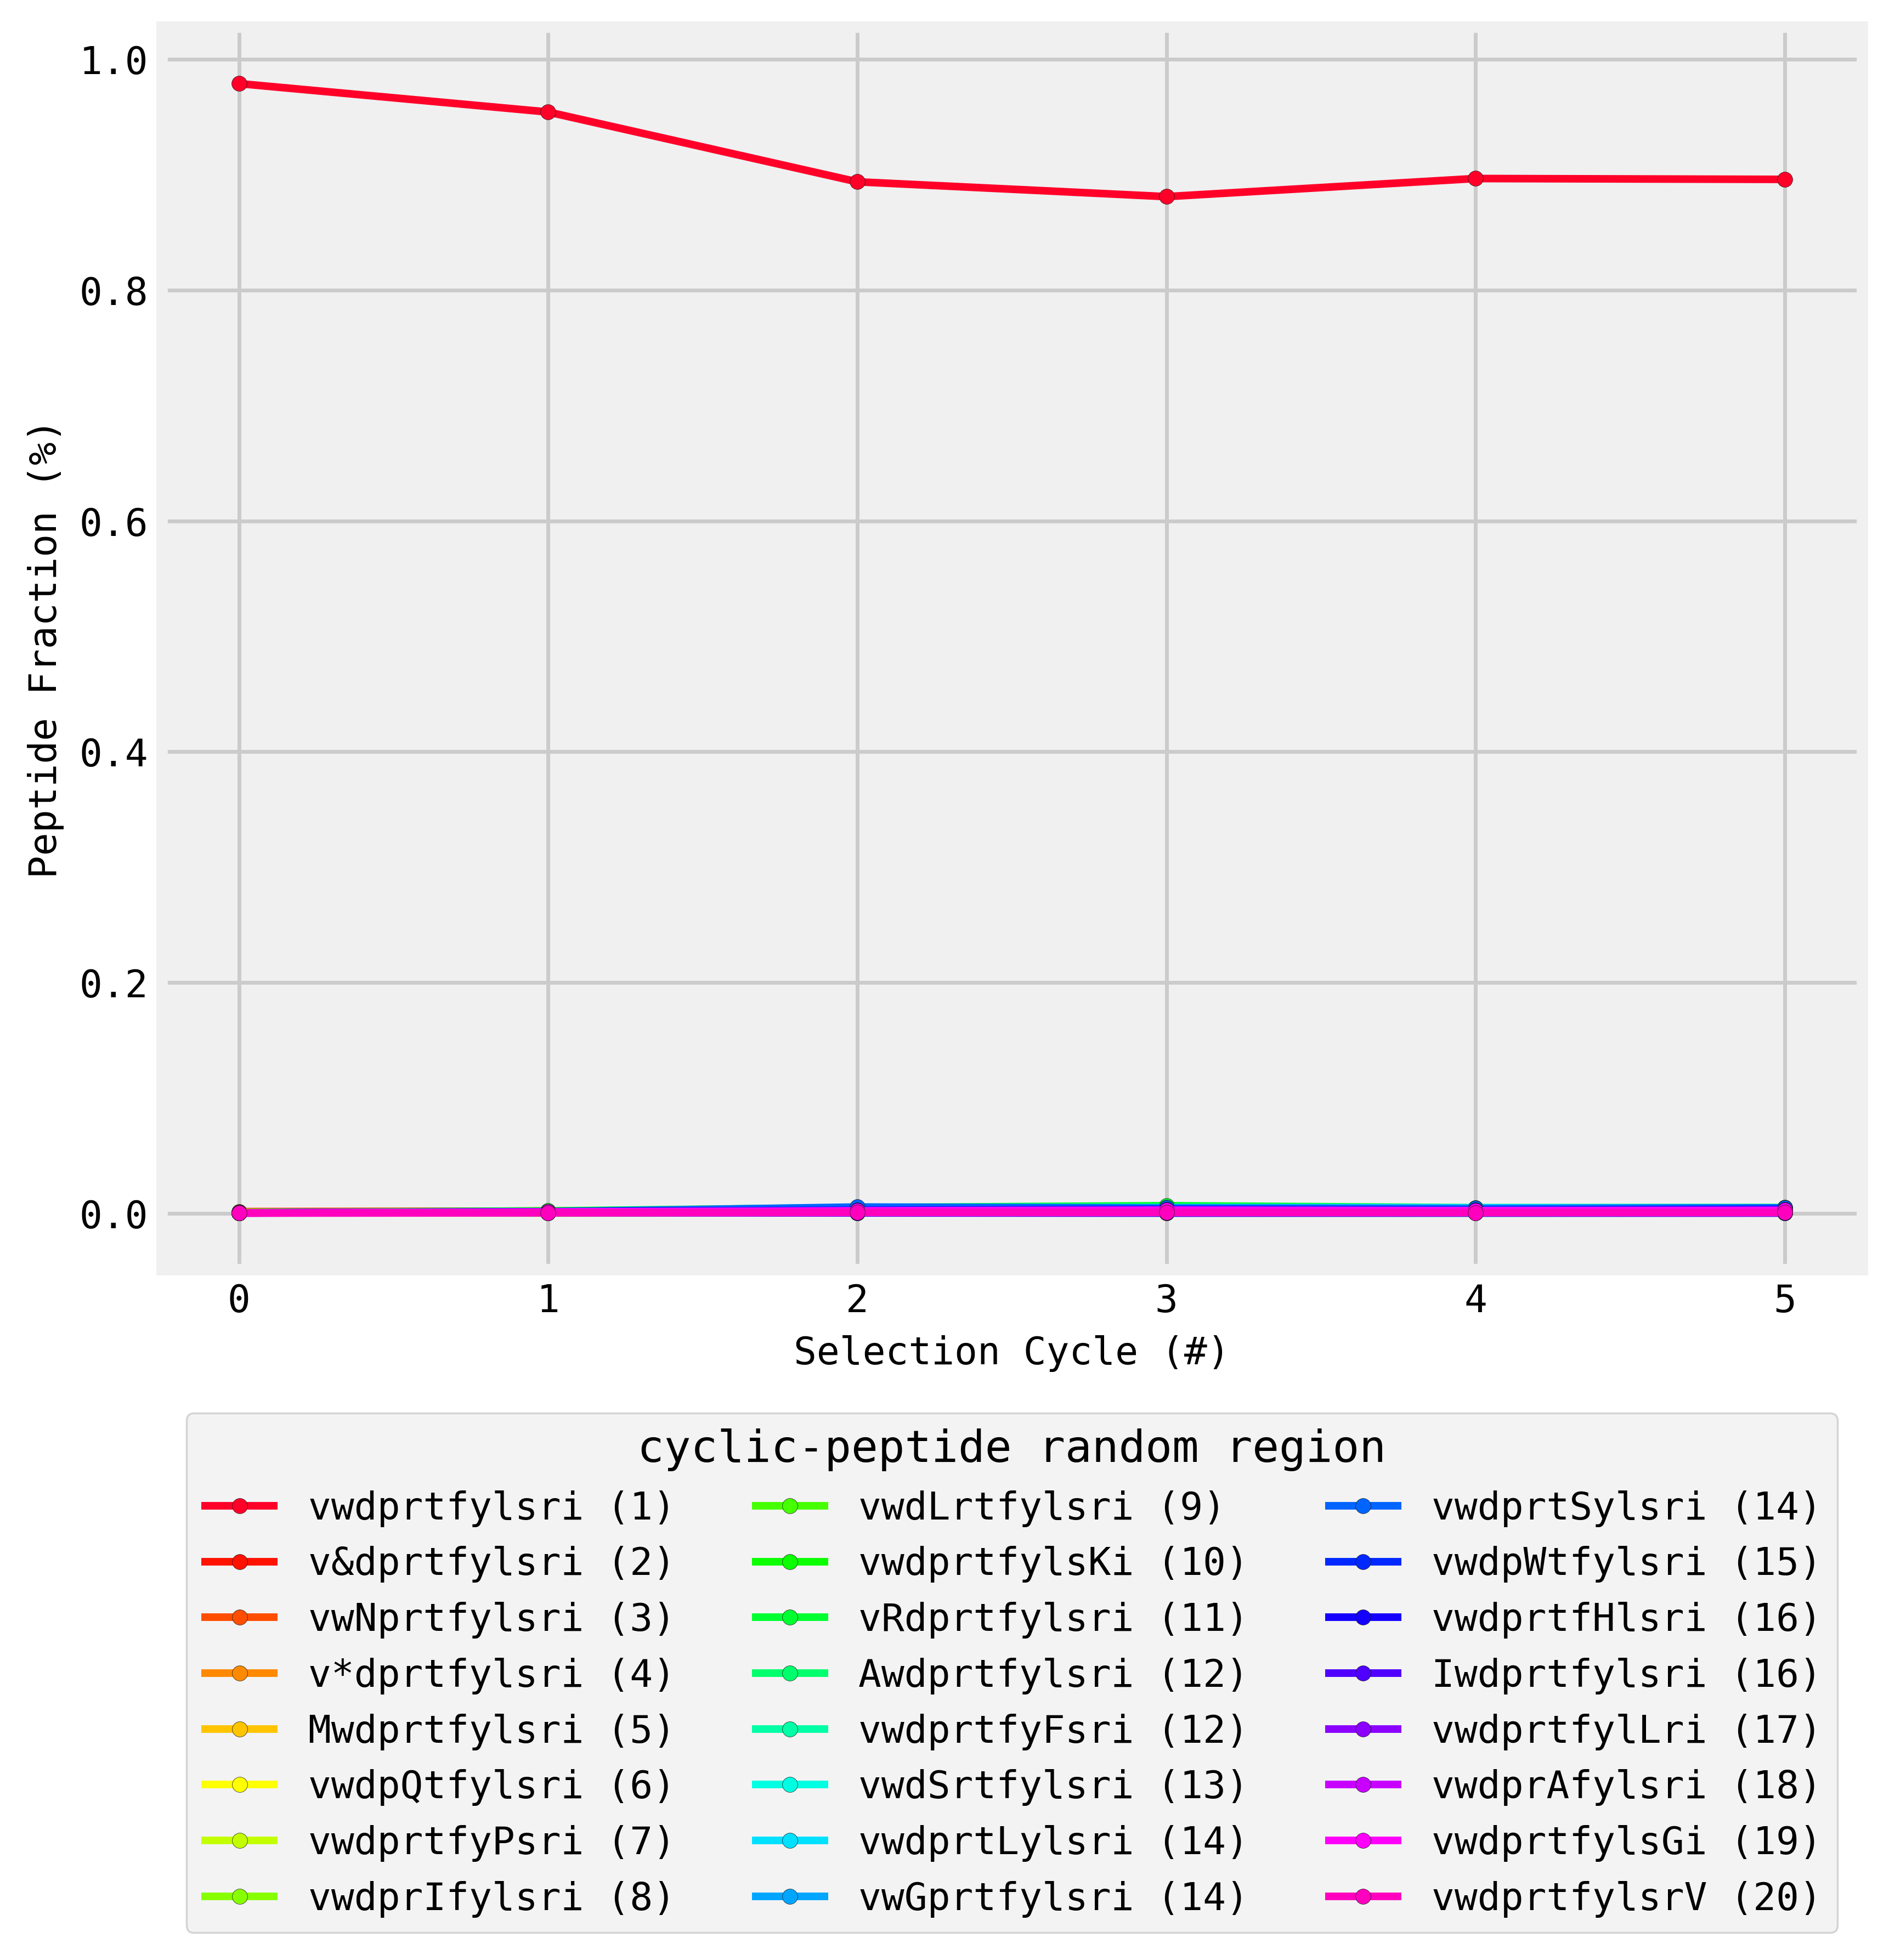

In [24]:
SelectionSummaryReport(DataFolderLocation,
                       BaseSelectionRoundNumber,
                       TopNPeptidesNumber,
                       StartSequence,
                       StopSequence,
                       cDNA_MinLength,
                       cDNA_MaxLength,
                       QualityScore,
                       FileName)

In [25]:
#DNAMutantsAnalysis(DataFolderLocation,
#                   BaseSelectionRoundNumber,
#                   TopNPeptidesNumber,
#                   StartSequence,
#                   StopSequence,
#                   FileName)

In [26]:
#PeptidesMutantsSummaryReport(DataFolderLocation,
#                             BaseSelectionRoundNumber,
#                             StartSequence,
#                             StopSequence,
#                             FileName)

In [27]:
#PeptidesRelatednessAnalysis(DataFolderLocation,
#                            BaseSelectionRoundNumber,
#                            TopNPeptidesNumber,
#                            StartSequence,
#                            StopSequence,
#                            cDNA_MinLength,
#                            cDNA_MaxLength,
#                            QualityScore,
#                            FileName)